In [ ]:
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate transformers ftfy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
%%time

!pip install -U --pre triton

from subprocess import getoutput
from IPython.display import HTML
from IPython.display import clear_output
import time

s = getoutput('nvidia-smi')
if 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
elif 'V100' in s:
  gpu = 'V100'
elif 'A100' in s:
  gpu = 'A100'

while True:
    try: 
        gpu=='T4'or gpu=='P100'or gpu=='V100'or gpu=='A100'
        break
    except:
        pass
    print('[1;31mit seems that your GPU is not supported at the moment')
    time.sleep(5)

if (gpu=='T4'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
  
elif (gpu=='P100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/P100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='V100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/V100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='A100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: HTTP error 404 while getting https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
ERROR: Could not install requirement xformers==0.0.13.dev0 from https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl because of HTTP error 404 Client Error: Not Found for url: https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl for URL https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
CPU times: user 114 ms, sys: 35.2 ms, total: 149 ms
Wall time: 11.7 s


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

In [ ]:
urls = [
      "https://i.imgur.com/RyAPsFe.jpg",
      "https://i.imgur.com/u1jWSPx.jpg",
      "https://i.imgur.com/qgjKcml.jpg",
      "https://i.imgur.com/JV6gMk3.jpg",
      "https://i.imgur.com/LslHy6G.jpg"
      #"https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
      ## You can add additional images here
]

In [ ]:
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.png") for i, image in enumerate(images)]

[None, None, None, None, None]

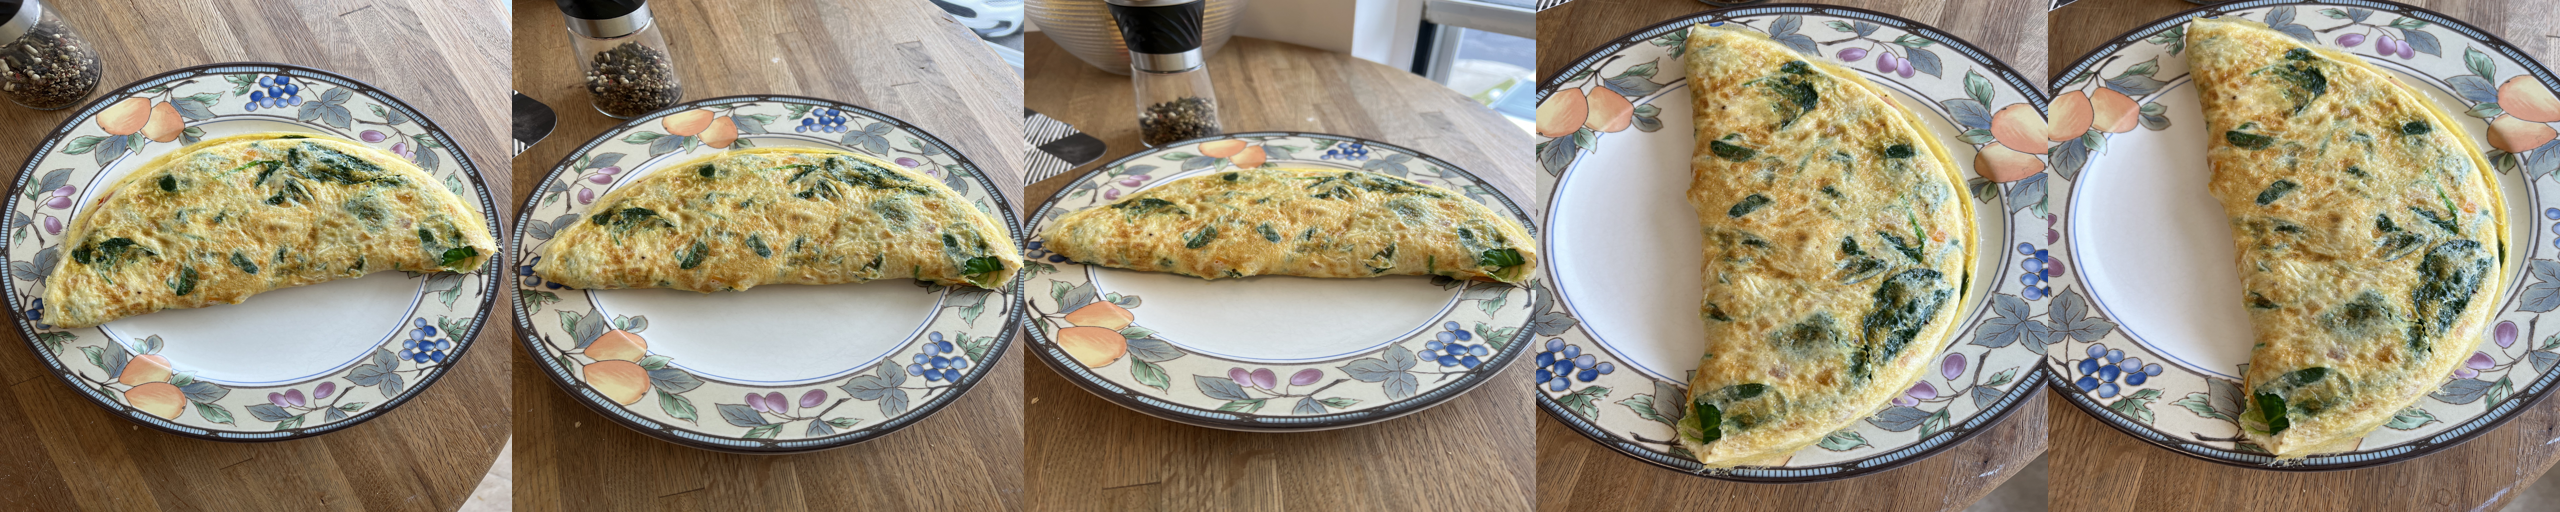

In [ ]:
images = []
for file_path in os.listdir(save_path):
  try:
      image_path = os.path.join(save_path, file_path)
      images.append(Image.open(image_path).resize((512, 512)))
  except:
    print(f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")
image_grid(images, 1, len(images))

In [ ]:
what_to_teach = "object" #@param ["object", "style"]
placeholder_token = "\u003Cegg-photo>" #@param {type:"string"}
initializer_token = "egg" #@param {type:"string"}

In [ ]:
imagenet_templates_small = [
    "a photo of a {} in a fancy american diner",
    "a rendering of a {} inside a french restaurant",
    "a cropped photo of the {} with ingredients used to make it",
    "the photo of a {}",
    "a photo of a clean fiery background {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of {} being eaten by a group of people enjoying their time",
    "a photo of the cool {} with beer",
    "a close-up photo of a {} inside a modular kitchen",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of a wooden board {}",
    "a photo of a chef preparing {}",
    "a photo of a sunny morning {}",
    "a photo of freshly squeezed orange juice with {}",
    "a photo of {} with chopped onions and tomatoes",
    "a photo {} with toast and coffee inside a american diner",
    "a photo of a cool {}",
    "a photo of a small {}",
]


In [ ]:
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [ ]:
from transformers import CLIPTokenizer, CLIPConfig,CLIPModel,CLIPTextConfig


tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

config = CLIPTextConfig.from_pretrained("openai/clip-vit-large-patch14")
config.attention_type = "custom"
config.custom_attention_config = {
    "num_heads": 8,
    "head_dim": 64,
    "dropout": 0.1
}


model.config = config


tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", model_max_length=model.config.max_position_embeddings)



# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )


'''import torch.nn as nn
from transformers import CLIPConfig

class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=config.hidden_size,
                nhead=config.num_attention_heads,
                dim_feedforward=config.intermediate_size,
                activation=config.hidden_act,
                dropout=config.hidden_dropout_prob,
                batch_first=True
            ),
            num_layers=config.num_hidden_layers
        )

    def forward(self, input_ids):
        attention_mask = (input_ids != 0).to(input_ids.device)
        output = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[0]
        return output

config = CLIPConfig.from_pretrained(pretrained_model_name_or_path)

text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder/config.json"
)
text_encoder.text_model.encoder = TransformerEncoder(config)


tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
config = CustomCLIPConfig.from_pretrained("openai/clip-vit-base-patch32")
config.attention_type = "custom"
config.custom_attention_config = {
    "num_heads": 8,
    "head_dim": 64,
    "dropout": 0.1
}
model = CLIP(config)

tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )'''

'import torch.nn as nn\nfrom transformers import CLIPConfig\n\nclass TransformerEncoder(nn.Module):\n    def __init__(self, config):\n        super().__init__()\n        self.transformer = nn.TransformerEncoder(\n            nn.TransformerEncoderLayer(\n                d_model=config.hidden_size,\n                nhead=config.num_attention_heads,\n                dim_feedforward=config.intermediate_size,\n                activation=config.hidden_act,\n                dropout=config.hidden_dropout_prob,\n                batch_first=True\n            ),\n            num_layers=config.num_hidden_layers\n        )\n\n    def forward(self, input_ids):\n        attention_mask = (input_ids != 0).to(input_ids.device)\n        output = self.transformer(\n            input_ids=input_ids,\n            attention_mask=attention_mask\n        )[0]\n        return output\n\nconfig = CLIPConfig.from_pretrained(pretrained_model_name_or_path)\n\ntext_encoder = CLIPTextModel.from_pretrained(\n    pretrai

In [ ]:
#@title Get token ids for our placeholder and initializer token. This code block will complain if initializer string is not a single token
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [ ]:
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

In [ ]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

In [ ]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [ ]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [ ]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

In [ ]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [ ]:
noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

/usr/local/lib/python3.8/dist-packages/diffusers/configuration_utils.py:195: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [ ]:
#from google.colab import drive  ## Mount Drive
#drive.mount('/content/drive')

In [ ]:
#import os
#os.chdir('/content/drive/MyDrive/Urban')

In [ ]:
hyperparameters = {
    "learning_rate": 2e-05,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir -p sd-concept-output

In [ ]:
pwd

'/content/drive/MyDrive/Urban'

In [ ]:
ls

 adult.data                    parent.xlsx
 adult_data.csv                pred.csv
 adult.names                   prediction_rf.csv
 adult.test                    prediction_rf.gsheet
 adult_test_1.csv              predictions_ANN.csv
 adult_test.csv                predictions_ANN.gsheet
 automobile.csv                predictions_DT.csv
 bed.csv                       predictions_DT.gsheet
 cases_by_county.csv           predictions_KNN.csv
 CONAN/                        predictions_KNN.gsheet
 DIALOCONAN/                   predictions_LR.csv
 dog_folder/                   predictions_LR.gsheet
 hospitals_with_waste.csv      prediction.xlsx
 imgs/                         RQ2_Excel.csv
 lp_adf_final.csv              Rq2.jpg
 Multitarget-CONAN/            sd-concept-output/
 multitarget_KN_grounded_CN/   sd_textual_inversion_training.ipynb
 my_concept/                  'STA_640_Homework_1 (1).ipynb'
 parent.csv                    Urban_Shared_Analysis/
 parent.gsheet                 wastew

In [ ]:
#@title Training function
logger = get_logger(__name__)

def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()

    
    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

In [ ]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/2000 [00:00<?, ?it/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
#@title Save your newly created concept to the [library of concepts](https://huggingface.co/sd-concepts-library)?

save_concept_to_public_library = True #@param {type:"boolean"}
name_of_your_concept = "omletteHAAI" #@param {type:"string"}
#@markdown `hf_token_write`: leave blank if you logged in with a token with `write access` in the [Initial Setup](#scrollTo=KbzZ9xe6dWwf). If not, [go to your tokens settings and create a write access token](https://huggingface.co/settings/tokens)
hf_token_write = "" #@param {type:"string"}

if(save_concept_to_public_library):
  from slugify import slugify
  from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
  from huggingface_hub import create_repo
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  output_dir = hyperparameters["output_dir"]
  if(not hf_token_write):
    with open(HfFolder.path_token, 'r') as fin: hf_token = fin.read();
  else:
    hf_token = hf_token_write
  #Join the Concepts Library organization if you aren't part of it already
  !curl -X POST -H 'Authorization: Bearer '$hf_token -H 'Content-Type: application/json' https://huggingface.co/organizations/sd-concepts-library/share/VcLXJtzwwxnHYCkNMLpSJCdnNFZHQwWywv
  images_upload = os.listdir("my_concept")
  image_string = ""
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  for i, image in enumerate(images_upload):
      image_string = f'''{image_string}![{placeholder_token} {i}](https://huggingface.co/{repo_id}/resolve/main/concept_images/{image})
'''
  if(what_to_teach == "style"):
      what_to_teach_article = f"a `{what_to_teach}`"
  else:
      what_to_teach_article = f"an `{what_to_teach}`"
  readme_text = f'''---
license: mit
---
### {name_of_your_concept} on Stable Diffusion
This is the `{placeholder_token}` concept taught to Stable Diffusion via Textual Inversion. You can load this concept into the [Stable Conceptualizer](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) notebook. You can also train your own concepts and load them into the concept libraries using [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb).

Here is the new concept you will be able to use as {what_to_teach_article}:
{image_string}
'''
  #Save the readme to a file
  readme_file = open("README.md", "w")
  readme_file.write(readme_text)
  readme_file.close()
  #Save the token identifier to a file
  text_file = open("token_identifier.txt", "w")
  text_file.write(placeholder_token)
  text_file.close()
  #Save the type of teached thing to a file
  type_file = open("type_of_concept.txt","w")
  type_file.write(what_to_teach)
  type_file.close()
  operations = [
    CommitOperationAdd(path_in_repo="learned_embeds.bin", path_or_fileobj=f"{output_dir}/learned_embeds.bin"),
    CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
    CommitOperationAdd(path_in_repo="type_of_concept.txt", path_or_fileobj="type_of_concept.txt"),
    CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
  ]
  create_repo(repo_id,private=True, token=hf_token)
  api = HfApi()
  api.create_commit(
    repo_id=repo_id,
    operations=operations,
    commit_message=f"Upload the concept {name_of_your_concept} embeds and token",
    token=hf_token
  )
  api.upload_folder(
    folder_path=save_path,
    path_in_repo="concept_images",
    repo_id=repo_id,
    token=hf_token
  )

You're already a member of sd-concepts-library!

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

learned_embeds.bin:   0%|          | 0.00/3.84k [00:00<?, ?B/s]

2.png:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

4.png:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

0.png:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

3.png:   0%|          | 0.00/15.2M [00:00<?, ?B/s]

1.png:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
ls

drive/       README.md     sd-concept-output/    type_of_concept.txt
my_concept/  sample_data/  token_identifier.txt


In [ ]:
cd sd-concept-output/

/content/sd-concept-output


In [ ]:
ls

feature_extractor/            learned_embeds-step-2000.bin  scheduler/
learned_embeds.bin            learned_embeds-step-250.bin   text_encoder/
learned_embeds-step-1000.bin  learned_embeds-step-500.bin   tokenizer/
learned_embeds-step-1250.bin  learned_embeds-step-750.bin   unet/
learned_embeds-step-1500.bin  model_index.json              vae/
learned_embeds-step-1750.bin  safety_checker/


# New Section

In [ ]:
#@title Set up the pipeline 
from diffusers import DPMSolverMultistepScheduler
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    scheduler=DPMSolverMultistepScheduler.from_pretrained(hyperparameters["output_dir"], subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

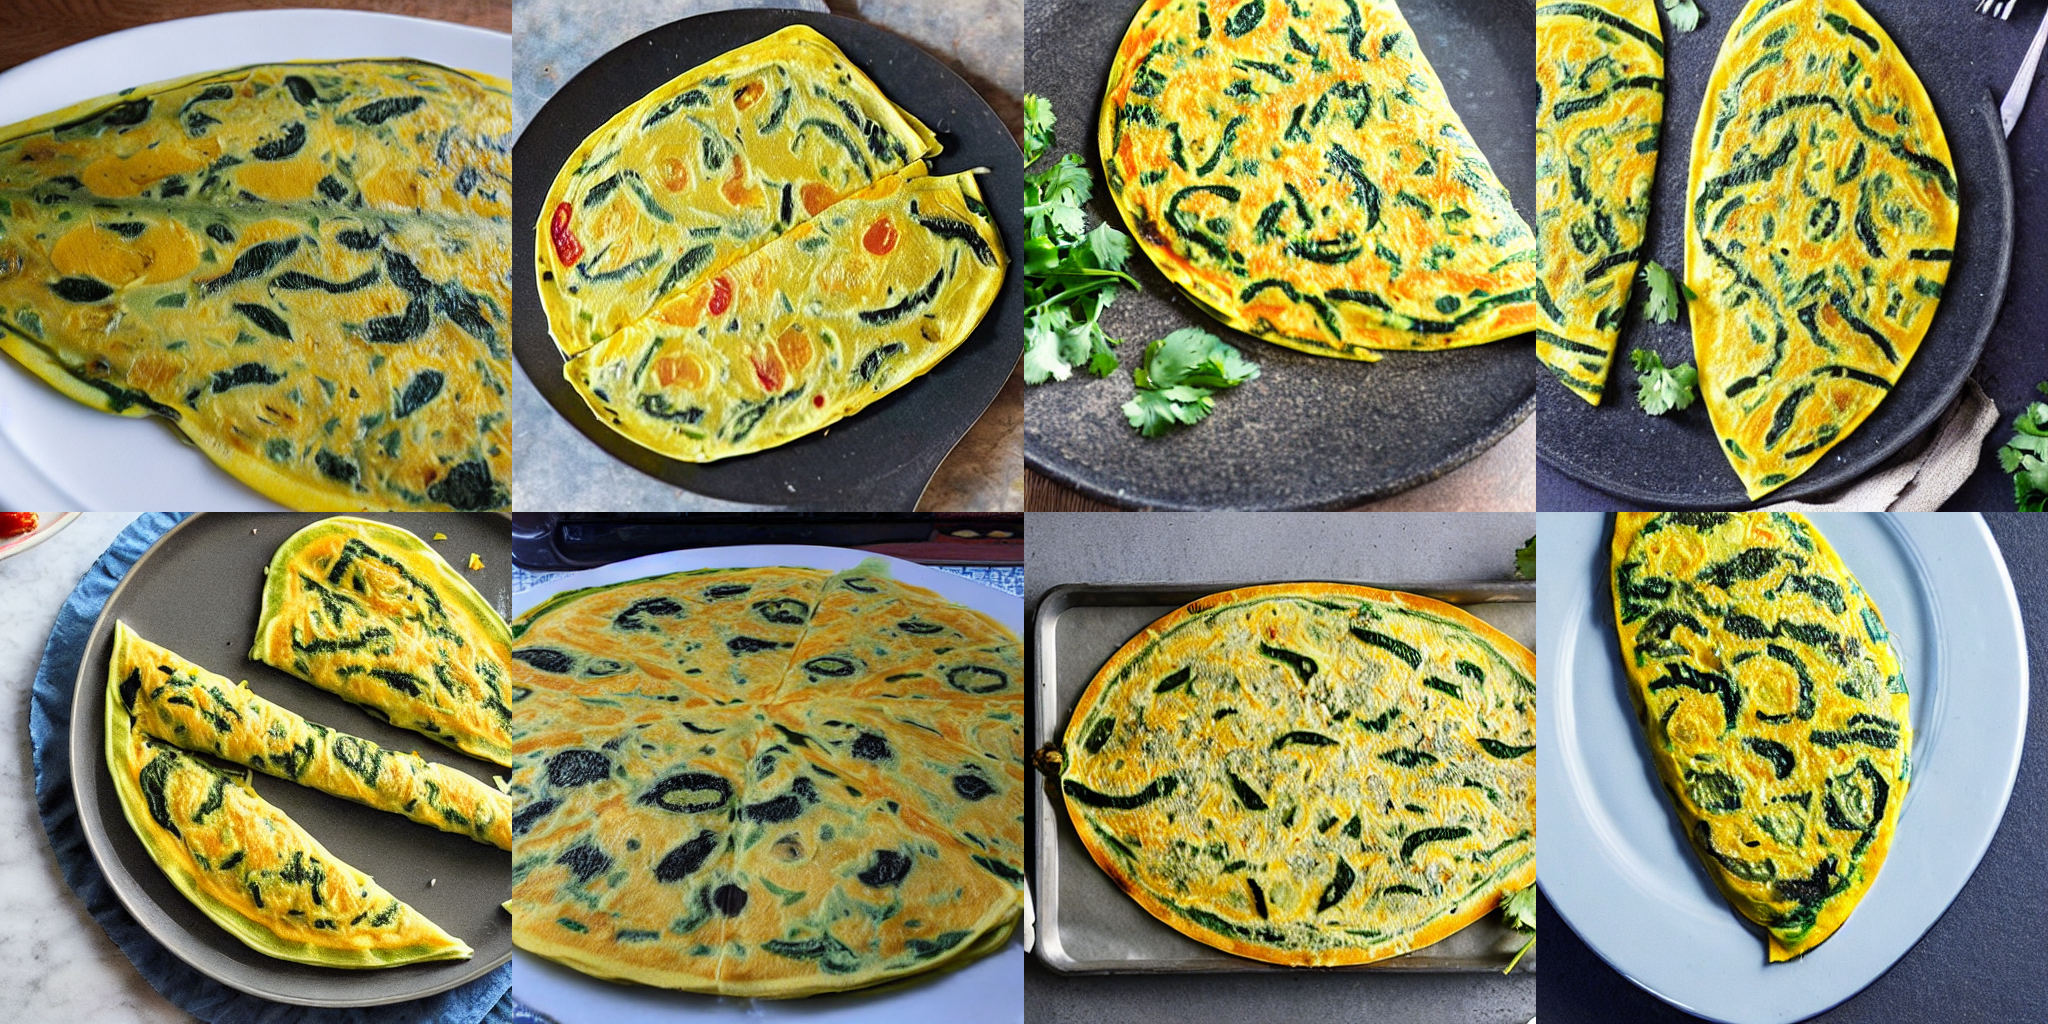

In [ ]:
prompt = "a photo of \u003Cegg-photo> deliciously cooked with peppers" #@param {type:"string"}

num_samples = 4 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=30, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

In [ ]:
pwd

'/content/sd-concept-output'

In [ ]:
cd ..

/content


In [ ]:
ls

drive/       README.md     sd-concept-output/    type_of_concept.txt
my_concept/  sample_data/  token_identifier.txt


In [ ]:
!zip -r /content/file.zip /content/Folder_To_Zip

	zip warning: name not matched: /content/Folder_To_Zip

zip error: Nothing to do! (try: zip -r /content/file.zip . -i /content/Folder_To_Zip)


In [ ]:
ls

drive/       README.md     sd-concept-output/    type_of_concept.txt
my_concept/  sample_data/  token_identifier.txt


In [ ]:
!zip -r /content/drive/MyDrive/file.zip /content/sd-concept-output

  adding: content/sd-concept-output/ (stored 0%)
  adding: content/sd-concept-output/feature_extractor/ (stored 0%)
  adding: content/sd-concept-output/feature_extractor/preprocessor_config.json (deflated 50%)
  adding: content/sd-concept-output/scheduler/ (stored 0%)
  adding: content/sd-concept-output/scheduler/scheduler_config.json (deflated 40%)
  adding: content/sd-concept-output/tokenizer/ (stored 0%)
  adding: content/sd-concept-output/tokenizer/merges.txt (deflated 60%)
  adding: content/sd-concept-output/tokenizer/tokenizer_config.json (deflated 66%)
  adding: content/sd-concept-output/tokenizer/vocab.json (deflated 71%)
  adding: content/sd-concept-output/tokenizer/special_tokens_map.json (deflated 73%)
  adding: content/sd-concept-output/tokenizer/added_tokens.json (stored 0%)
  adding: content/sd-concept-output/learned_embeds-step-500.bin (deflated 16%)
  adding: content/sd-concept-output/learned_embeds-step-1250.bin (deflated 16%)
  adding: content/sd-concept-output/learne

In [ ]:
ls

drive/    my_concept/  sample_data/        token_identifier.txt
file.zip  README.md    sd-concept-output/  type_of_concept.txt


In [ ]:
cd drive/

/content/drive


In [ ]:
ls

MyDrive/  Shareddrives/


In [ ]:
cd MyDrive/

/content/drive/MyDrive


'14-Combating Bias in Recidivism-Rohan.gslides'
 ACCESS.docx
'Aerospace_Corp (1).pptx'
' Analyzing religious rhetoric to spread misinformation among the ongoing farmers protest in India.gdoc'
 aneeser24.c06.1.c.out.gdoc
 aneeser24.c06.1.c.out.txt
'annontatedFarmersData (1).csv'
'annontatedFarmersData - annontatedFarmersData.csv'
'annontatedFarmersData - annontatedFarmersData.gsheet'
 annontatedFarmersData.csv
 annontatedFarmersData.gsheet
 annontatedFarmersData_new.csv
 ASR_Drive/
 Assessor_Slides.gslides
 assignment_1/
'bookingconfirmation (1).gdoc'
'bookingconfirmation (1).pdf'
 bookingconfirmation.gdoc
 bookingconfirmation.pdf
'Citi Bike analysis.gsheet'
'Colab Notebooks'/
"Copy of Applied Computational Linguistics Master's Thesis by Slidesgo.gslides"
'Copy of rohan100.xlsx'
"Copy of Rohan_SAIL Storyline and Pre-Paper Talks: Farmer's Protest.docx"
 Covid_Bed_Utilization.pptx
'Covid Tweet Dataset.gsheet'
 CovidVaccineHesitancy.gsheet
'CSS & Individual Paper 2.gdoc'
 CSS_SLIDES.gslide